Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

the structure of cnn is:


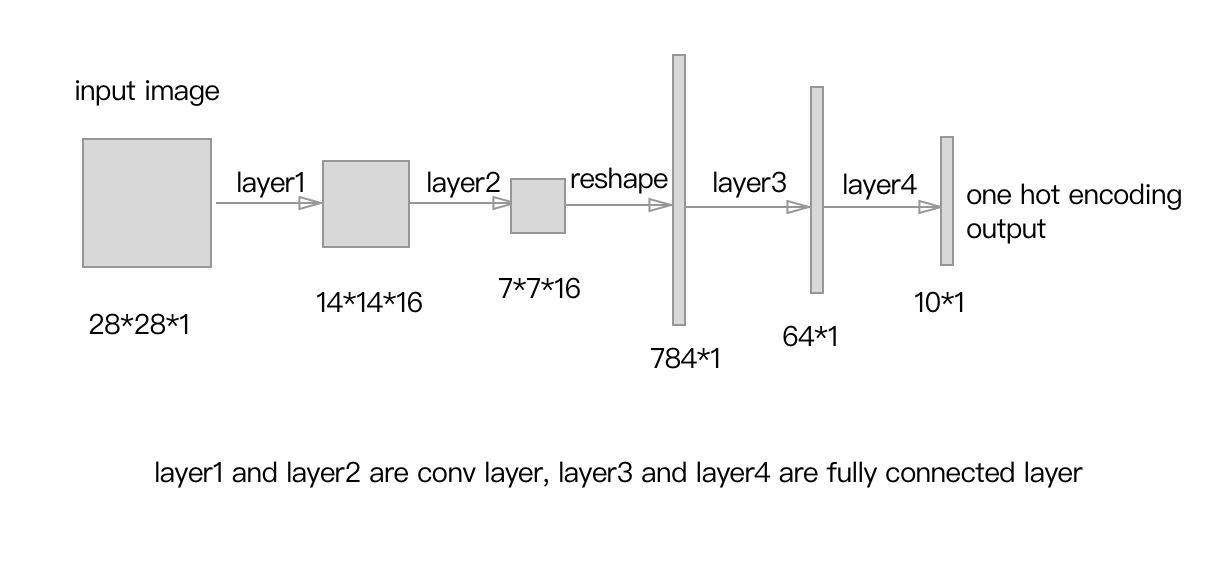

In [6]:
# 我对上述神经网络结构的理解
from IPython.display import display, Image
print("the structure of cnn is:")
display(Image(filename="./imgs/4_cnn.png"))

In [7]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.820060
Minibatch accuracy: 12.5%
Validation accuracy: 9.8%
Minibatch loss at step 50: 1.590605
Minibatch accuracy: 31.2%
Validation accuracy: 58.9%
Minibatch loss at step 100: 0.873222
Minibatch accuracy: 50.0%
Validation accuracy: 69.9%
Minibatch loss at step 150: 0.352712
Minibatch accuracy: 87.5%
Validation accuracy: 74.8%
Minibatch loss at step 200: 0.944558
Minibatch accuracy: 75.0%
Validation accuracy: 77.1%
Minibatch loss at step 250: 1.428187
Minibatch accuracy: 56.2%
Validation accuracy: 77.9%
Minibatch loss at step 300: 0.401691
Minibatch accuracy: 87.5%
Validation accuracy: 79.1%
Minibatch loss at step 350: 0.509819
Minibatch accuracy: 87.5%
Validation accuracy: 76.8%
Minibatch loss at step 400: 0.344125
Minibatch accuracy: 93.8%
Validation accuracy: 80.1%
Minibatch loss at step 450: 0.845220
Minibatch accuracy: 75.0%
Validation accuracy: 79.8%
Minibatch loss at step 500: 0.723176
Minibatch accuracy: 81.2%
Validation accuracy: 79.7%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [8]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [9]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.538265
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.290854
Minibatch accuracy: 12.5%
Validation accuracy: 21.4%
Minibatch loss at step 100: 1.859604
Minibatch accuracy: 25.0%
Validation accuracy: 41.2%
Minibatch loss at step 150: 0.783054
Minibatch accuracy: 81.2%
Validation accuracy: 68.5%
Minibatch loss at step 200: 0.815103
Minibatch accuracy: 81.2%
Validation accuracy: 74.7%
Minibatch loss at step 250: 1.218063
Minibatch accuracy: 62.5%
Validation accuracy: 75.0%
Minibatch loss at step 300: 0.479618
Minibatch accuracy: 81.2%
Validation accuracy: 79.2%
Minibatch loss at step 350: 0.452131
Minibatch accuracy: 93.8%
Validation accuracy: 77.0%
Minibatch loss at step 400: 0.272802
Minibatch accuracy: 93.8%
Validation accuracy: 80.1%
Minibatch loss at step 450: 0.755861
Minibatch accuracy: 87.5%
Validation accuracy: 79.4%
Minibatch loss at step 500: 0.602252
Minibatch accuracy: 81.2%
Validation accuracy: 81.2%
Mi

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

the structure of lenet5 is:


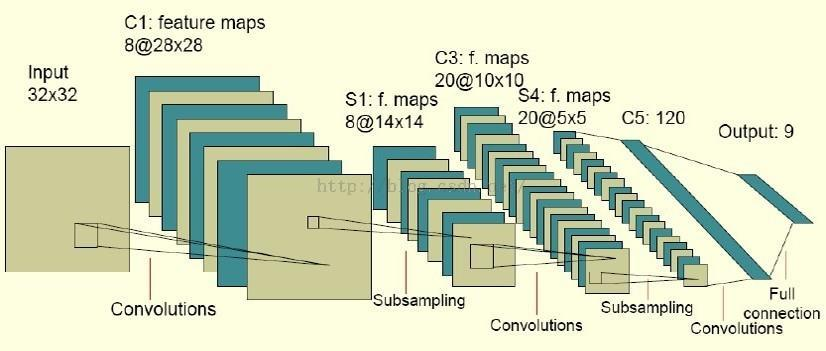

In [10]:
from IPython.display import display, Image
print("the structure of lenet5 is:")
display(Image(filename="./imgs/4_lenet5.jpeg"))

the structure I constructed is:


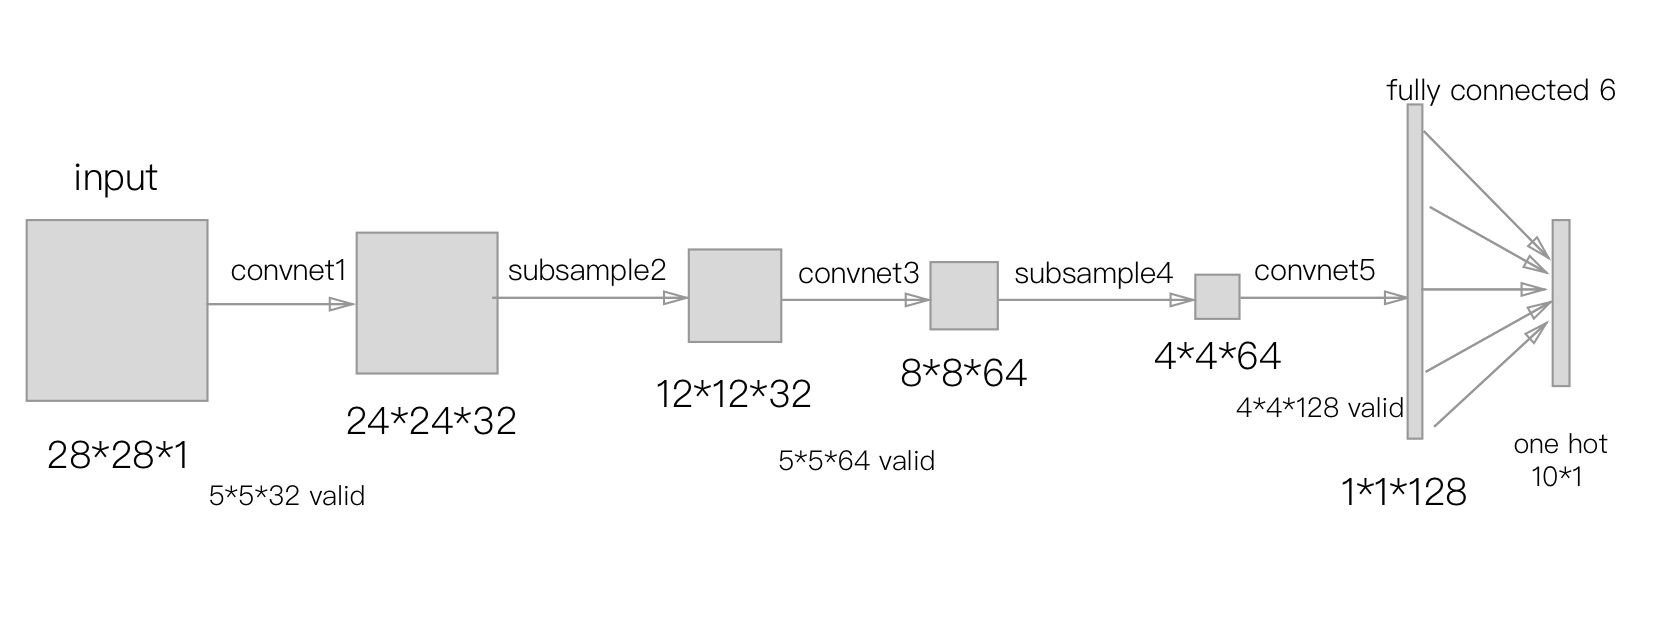

In [11]:
# 我的模型
print("the structure I constructed is:")
display(Image(filename="./imgs/4_my_lenet.png"))

In [12]:
batch_size = 128
patch_size = 5
patch_size2 = 4
depth = 32
depth2 = 64
depth3 = 128

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  
  layer3_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth2], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    
  layer5_weights = tf.Variable(tf.truncated_normal(
      [patch_size2, patch_size2, depth2, depth3], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[depth3]))

  layer6_weights = tf.Variable(tf.truncated_normal(
      [depth3 , num_labels], stddev=0.1))
  layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    # C1, 1@28x28-in, 32@24x24-out
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    
    # S2, 32@24x24-in, 32@12x12-out
    pool2 = tf.nn.avg_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    # C3, 32@12x12-in, 64@8x8-out
    conv3 = tf.nn.conv2d(pool2, layer3_weights, [1, 1, 1, 1], padding='VALID')
    bias3 = tf.nn.relu(conv3 + layer3_biases)
    
    # S4, 64@8x8-in, 64@4x4-out
    pool4 = tf.nn.avg_pool(bias3, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    # C5, 64@4x4-in, 128@1x1-out
    conv5 = tf.nn.conv2d(pool4, layer5_weights, [1, 1, 1, 1], padding='VALID')
    bias5 = tf.nn.relu(conv5 + layer5_biases)
    
    # F6, 128-in, 10-out
    shape = bias5.get_shape().as_list()
    reshape = tf.reshape(bias5, [shape[0], shape[1] * shape[2] * shape[3]])
    return tf.matmul(reshape, layer6_weights) + layer6_biases
  

  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [13]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.932986
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.140626
Minibatch accuracy: 68.0%
Validation accuracy: 66.4%
Minibatch loss at step 100: 0.880117
Minibatch accuracy: 75.0%
Validation accuracy: 75.7%
Minibatch loss at step 150: 0.990190
Minibatch accuracy: 72.7%
Validation accuracy: 77.7%
Minibatch loss at step 200: 0.696222
Minibatch accuracy: 80.5%
Validation accuracy: 77.0%
Minibatch loss at step 250: 0.566733
Minibatch accuracy: 84.4%
Validation accuracy: 78.8%
Minibatch loss at step 300: 0.710938
Minibatch accuracy: 75.0%
Validation accuracy: 80.3%
Minibatch loss at step 350: 0.542858
Minibatch accuracy: 83.6%
Validation accuracy: 80.2%
Minibatch loss at step 400: 0.746325
Minibatch accuracy: 76.6%
Validation accuracy: 81.1%
Minibatch loss at step 450: 0.554296
Minibatch accuracy: 85.2%
Validation accuracy: 81.6%
Minibatch loss at step 500: 0.461107
Minibatch accuracy: 88.3%
Validation accuracy: 82.5%
M